In [4]:
import sys
import tensorflow as tf
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt
from skimage.util import montage as montage2d
from glob import glob
import numpy as np
from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [6]:
sys.path.append("..")
from spatial_transform.aff_mnist_data import IMAGE_SIZE, IMAGE_SHAPE, IMAGE_NUM_CHANNELS, get_aff_mnist_data
from spatial_transform.spatial_transforms import AffineTransform, QuadraticTransform
from spatial_transform.st_blocks import SimpleSpatialTransformBlock
from spatial_transform.localization import StandardConvolutionalLocalizationLayer, CoordConvLocalizationLayer, LargeLocalizationLayer
from spatial_transform.interpolation import BilinearInterpolator
from spatial_transform.layers import RepeatWithSharedWeights, LayerChain
from spatial_transform.visualization import show_train_progress

In [13]:
train_img_data, train_img_label, validation_img_data, validation_img_label, test_img_data, test_img_label = get_aff_mnist_data()

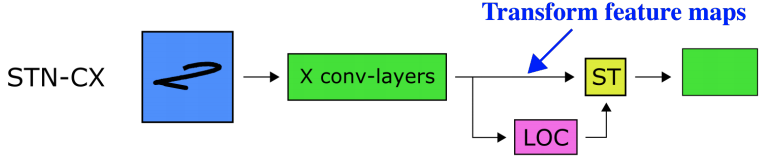

In [5]:
Image("../images/stn_cx.png")

We repete this block 3 times with shared weights

In [12]:
image = tf.keras.layers.Input(shape=IMAGE_SHAPE + (IMAGE_NUM_CHANNELS,))
size_after_transform = 28
num_channels = 16

spatial_transform = AffineTransform()
st_block = SimpleSpatialTransformBlock(
    localization_layer = CoordConvLocalizationLayer(
        spatial_transform_params_cls = spatial_transform.param_type,
        init_scale = 1,
    ),
    spatial_transform = spatial_transform,
    interpolator = BilinearInterpolator(),
    shape_out = (size_after_transform, size_after_transform)
)
stn_cx_block = LayerChain([st_block, tf.keras.layers.Conv2D(num_channels, [5, 5], activation='relu', padding="same")])
stn_cx_chain = RepeatWithSharedWeights(layer=stn_cx_block, num_repetitions=3)

x = tf.image.resize(image, size=(size_after_transform, size_after_transform))
x = tf.keras.layers.Lambda(lambda x: tf.tile(x, [1,1,1,num_channels]))(x)
x = stn_cx_chain(x)
x = tf.keras.layers.Conv2D(32, [5, 5], activation='relu', padding="valid")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, [5, 5], activation='relu', padding="valid")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation=None)(x)

model = tf.keras.models.Model(inputs=image, outputs=x)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 40, 40, 1)]       0         
_________________________________________________________________
tf.image.resize_4 (TFOpLambd (None, 28, 28, 1)         0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 28, 28, 16)        0         
_________________________________________________________________
repeat_with_shared_weights_4 (None, 28, 28, 16)        25574     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 32)        12832     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 32)          2563

In [14]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [15]:
history = model.fit(
    x = train_img_data, 
    y = train_img_label, 
    batch_size = 128,
    epochs = 6,
    validation_data = (test_img_data,  test_img_label),
    validation_batch_size = 1024,
)

Epoch 1/6
12500/12500 [==============================] - 666s 53ms/step - loss: 1.4052 - accuracy: 0.5198 - val_loss: 0.1669 - val_accuracy: 0.9471
Epoch 2/6
12500/12500 [==============================] - 620s 50ms/step - loss: 0.1605 - accuracy: 0.9493 - val_loss: 0.0953 - val_accuracy: 0.9694
Epoch 3/6
12500/12500 [==============================] - 609s 49ms/step - loss: 0.1186 - accuracy: 0.9622 - val_loss: 0.0766 - val_accuracy: 0.9759
Epoch 4/6
12500/12500 [==============================] - 604s 48ms/step - loss: 0.0662 - accuracy: 0.9792 - val_loss: 0.0441 - val_accuracy: 0.9861
Epoch 5/6
12500/12500 [==============================] - 620s 50ms/step - loss: 0.0497 - accuracy: 0.9844 - val_loss: 0.0454 - val_accuracy: 0.9852
Epoch 6/6
12500/12500 [==============================] - 647s 52ms/step - loss: 0.0815 - accuracy: 0.9730 - val_loss: 0.0597 - val_accuracy: 0.9812


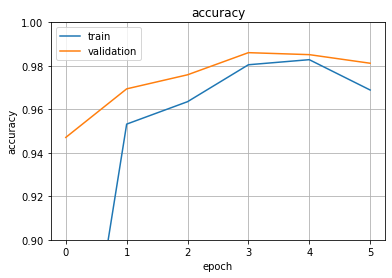

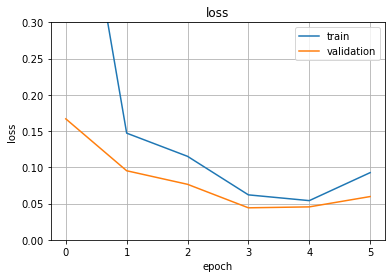

In [16]:
show_train_progress(history)

In [17]:
#model.save_weights("STN_CX_backbone.h5")

### Investigate transformed features

In [21]:
labels = test_img_label[0:20]
images = tf.cast(tf.expand_dims(test_img_data[0:20], 3), dtype=tf.float32)

In [22]:
x = tf.image.resize(images, size=(size_after_transform, size_after_transform))
x = tf.keras.layers.Lambda(lambda x: tf.tile(x, [1,1,1,num_channels]))(x)
transformed_images = stn_cx_chain(x)

0


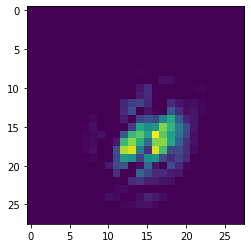

1


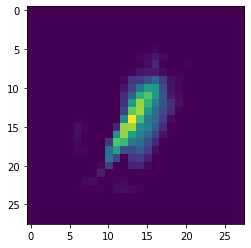

2


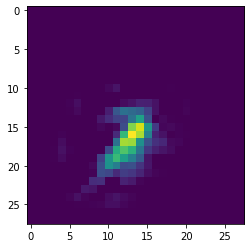

7


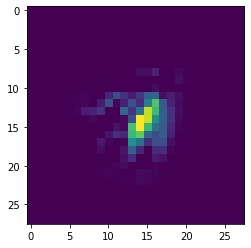

3


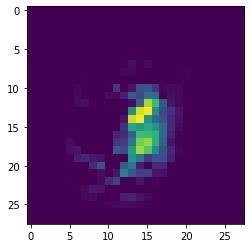

9


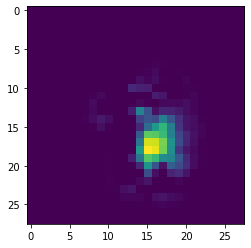

4


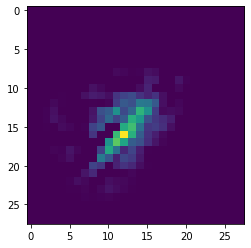

8


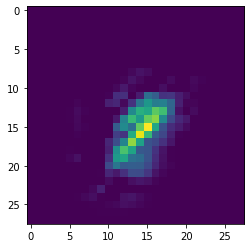

6


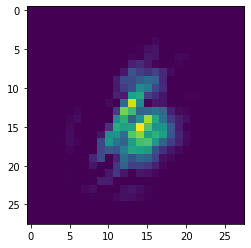

5


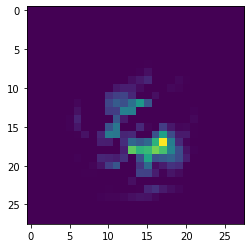

1


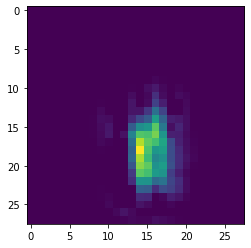

2


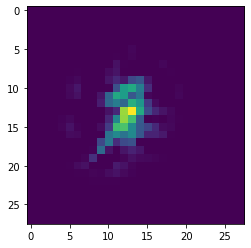

7


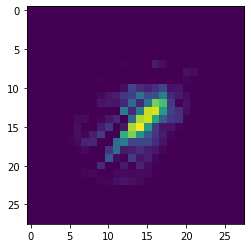

3


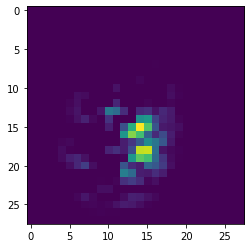

9


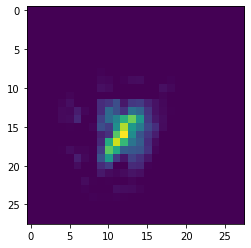

4


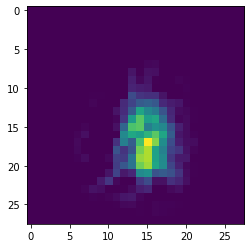

0


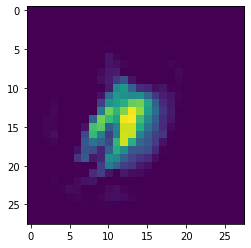

8


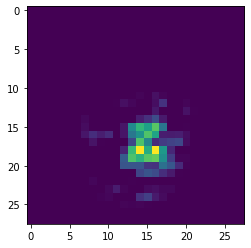

6


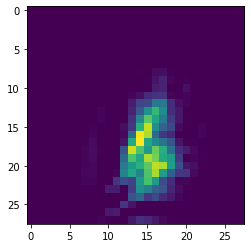

5


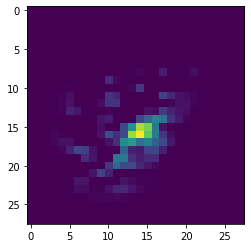

In [25]:
for image, label in zip(transformed_images, labels):
    print(label)
    plt.imshow(image.numpy()[:,:,2])
    plt.show()
